In [2]:
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor


In [3]:
import os
os.listdir()

['mercari',
 '.ipynb_checkpoints',
 'README.md',
 'Price Prediction.ipynb',
 '.git']

In [7]:
os.getcwd()

'/home/swap9047/Desktop/PricePrediction_Kaggle/RetailPrice_Recommendation'

In [8]:
df = pd.read_csv('./mercari/train.tsv', sep = '\t')

In [9]:
train,test=train_test_split(df,train_size=0.75,random_state=101)

/home/swap9047/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1111901 entries, 222185 to 1225567
Data columns (total 8 columns):
train_id             1111901 non-null int64
name                 1111901 non-null object
item_condition_id    1111901 non-null int64
category_name        1107158 non-null object
brand_name           637249 non-null object
price                1111901 non-null float64
shipping             1111901 non-null int64
item_description     1111898 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 76.3+ MB


In [11]:
train.describe()

,train_id,item_condition_id,price,shipping
count,1.111901e+06,1.111901e+06,1.111901e+06,1.111901e+06
mean,7.410857e+05,1.907727e+00,2.672155e+01,4.468932e-01
std,4.279725e+05,9.034699e-01,3.852468e+01,4.971719e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.704820e+05,1.000000e+00,1.000000e+01,0.000000e+00
50%,7.409870e+05,2.000000e+00,1.700000e+01,0.000000e+00
75%,1.111658e+06,3.000000e+00,2.900000e+01,1.000000e+00
max,1.482532e+06,5.000000e+00,2.009000e+03,1.000000e+00


Text(0.5,1,'Price Distribution')

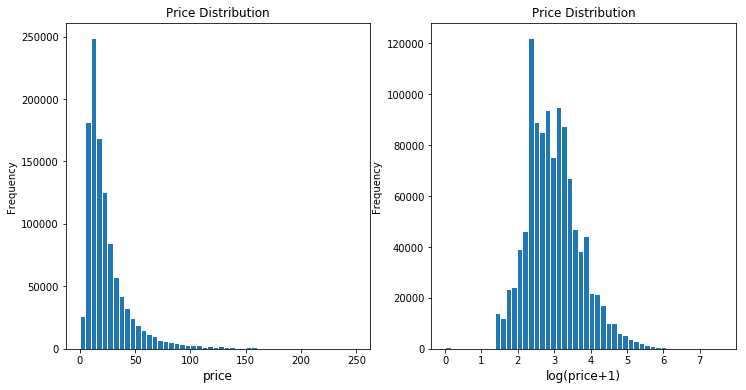

In [12]:
plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)
plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(12,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Price Distribution', fontsize=12)


In [13]:
train['shipping'].value_counts() / len(train)

0    0.553107
1    0.446893
Name: shipping, dtype: float64

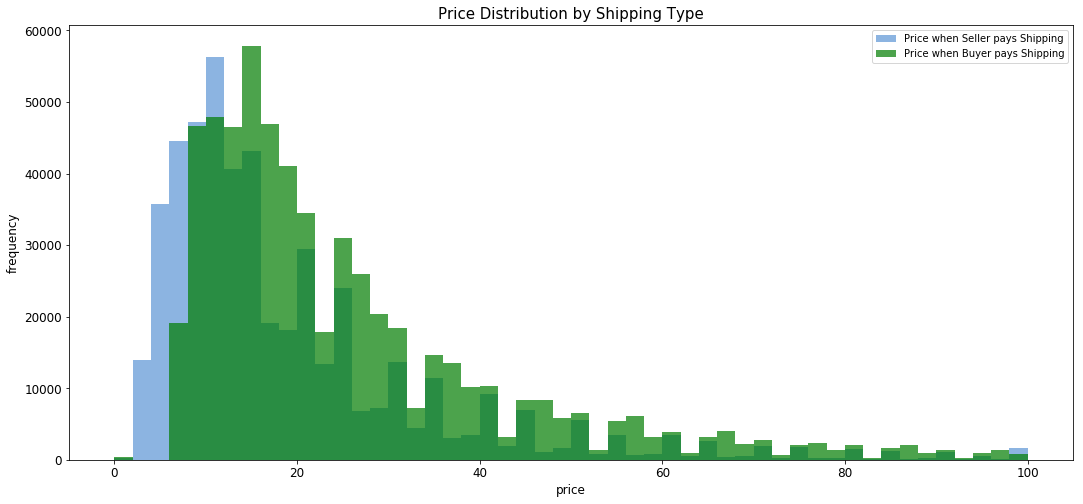

In [14]:
shipping_fee_by_buyer = train.loc[df['shipping'] == 0, 'price']
shipping_fee_by_seller = train.loc[df['shipping'] == 1, 'price']
fig, ax = plt.subplots(figsize=(18,8))
ax.hist(shipping_fee_by_seller, color='#8CB4E1', alpha=1.0, bins=50, range = [0, 100],
       label='Price when Seller pays Shipping')
ax.hist(shipping_fee_by_buyer, color='#007D00', alpha=0.7, bins=50, range = [0, 100],
       label='Price when Buyer pays Shipping')
plt.xlabel('price', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

In [15]:
print('The average price is {}'.format(round(shipping_fee_by_seller.mean(), 2)), 'if seller pays shipping');
print('The average price is {}'.format(round(shipping_fee_by_buyer.mean(), 2)), 'if buyer pays shipping')

The average price is 22.54 if seller pays shipping
The average price is 30.1 if buyer pays shipping


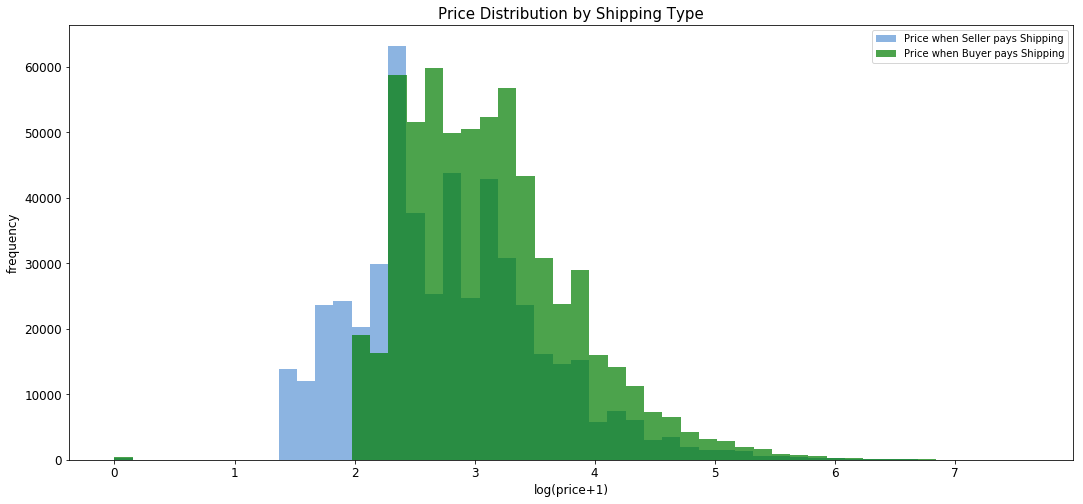

In [16]:
fig, ax = plt.subplots(figsize=(18,8))
ax.hist(np.log(shipping_fee_by_seller+1), color='#8CB4E1', alpha=1.0, bins=50,
       label='Price when Seller pays Shipping')
ax.hist(np.log(shipping_fee_by_buyer+1), color='#007D00', alpha=0.7, bins=50,
       label='Price when Buyer pays Shipping')
plt.xlabel('log(price+1)', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

In [17]:
print('There are', train['category_name'].nunique(), 'unique values in category name column')

There are 1268 unique values in category name column


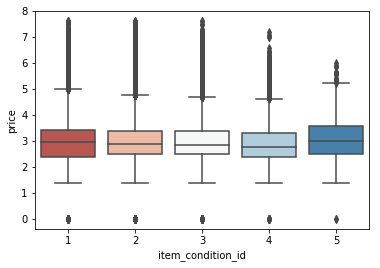

In [18]:
sns.boxplot(x = 'item_condition_id', y = np.log(train['price']+1), data = train, palette = sns.color_palette('RdBu',5))

In [21]:
NUM_BRANDS = 4000
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 50000

In [22]:
def handle_missing_inplace(dataset): 
    dataset['category_name'].fillna(value='missing', inplace=True) 
    dataset['brand_name'].fillna(value='missing', inplace=True) 
    dataset['item_description'].replace('No description yet,''missing', inplace=True) 
    dataset['item_description'].fillna(value='missing', inplace=True)
def cutting(dataset):
    pop_brand = dataset['brand_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    pop_category = dataset['category_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]
def to_categorical(dataset):
    dataset['category_name'] = dataset['category_name'].astype('category')
    dataset['brand_name'] = dataset['brand_name'].astype('category')
    dataset['item_condition_id'] = dataset['item_condition_id'].astype('category')

In [24]:
df = pd.read_csv('./mercari/train.tsv', sep = '\t')
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]
test_new = test.drop('price', axis=1)
y_test = np.log1p(test["price"])
train = train[train.price != 0].reset_index(drop=True)

In [25]:
nrow_train = train.shape[0]
y = np.log1p(train["price"])
merge: pd.DataFrame = pd.concat([train, test_new])

In [26]:
handle_missing_inplace(merge)
cutting(merge)
to_categorical(merge)

In [27]:
cv = CountVectorizer(min_df=NAME_MIN_DF)
X_name = cv.fit_transform(merge['name'])
cv = CountVectorizer()
X_category = cv.fit_transform(merge['category_name'])

In [28]:
tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION, ngram_range=(1, 3), stop_words='english')
X_description = tv.fit_transform(merge['item_description'])

In [29]:
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(merge['brand_name'])